In [1]:
import pandas as pd

In [2]:
from google.cloud import bigquery

In [6]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"c:\Users\LENOVO\Desktop\Keys\climate-hertie-97ed8409e1e2.json"


In [7]:
client = bigquery.Client()

In [8]:
query = """
SELECT DISTINCT 
    MonthYear,
    SOURCEURL,
    AvgTone,
FROM `gdelt-bq.gdeltv2.events`
WHERE (Actor1CountryCode = 'SOM')
AND SQLDATE BETWEEN 20240601 AND 20241231  
AND LOWER(SOURCEURL) LIKE '%drought%'
LIMIT 10;
"""

# Estimate query cost
job_config = bigquery.QueryJobConfig(dry_run=True)
query_job = client.query(query, job_config=job_config)  # Dry run to estimate cost

data_processed_gb = query_job.total_bytes_processed / (1024**3)  # Convert bytes to GB
cost_usd = max(0, data_processed_gb - 1) * 5  # Free tier is 1 TB, cost is $5 per TB after


# Run the query and store the result in a DataFrame
df = client.query(query).to_dataframe()

print(df.head())

# Print estimated query cost and remaining free-tier quota
print(f"Data Processed: {data_processed_gb:.3f} GB")
print(f"Estimated Cost: ${cost_usd:.2f} (after 1 TB free limit)")

Forbidden: 403 Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas; reason: quotaExceeded, location: unbilled.analysis, message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 94247819-eb6a-4ac9-9ebf-d222add16ca3


In [7]:
df['EventRootCode']

0    11
1    18
2    09
3    01
4    17
5    02
6    08
7    19
8    02
9    04
Name: EventRootCode, dtype: object

In [ ]:
data_processed_tb = query_job.total_bytes_processed / (1024**4)
print(f"Free-Tier Remaining: {max(0, 1 - data_processed_tb):.6f} TB")

Free-Tier Remaining: 0.905896 TB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

<Axes: xlabel='Date'>

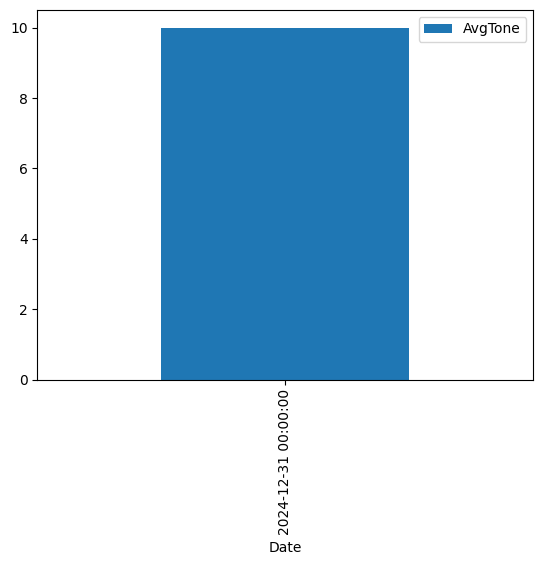

In [10]:
df.groupby('Date').count().plot(y='AvgTone', kind='bar')

In [7]:
min_date_str = df['Date'].min().strftime('%Y-%m-%d')
max_date_str = df['Date'].max().strftime('%Y-%m-%d')


df.to_csv(f'data/somalia_climate_change_from_{min_date_str}_to_{max_date_str}.csv', index=False)